# Fast absolute deadband sampling in python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let's say we want to sample a signal, like the cosine below, using absolute deadband sampling.

In [2]:
t = np.arange(0, 4*np.pi, np.pi/200.)
sig = np.cos(t)

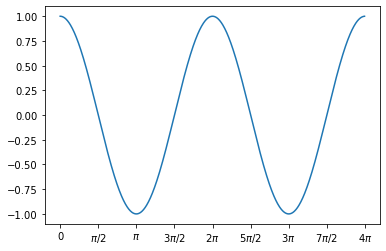

In [3]:
ax = plt.gca()
ax.plot(t,sig)
ax.set_xticks(np.arange(0, 4*np.pi+.1, np.pi/2))
tt = ax.set_xticklabels(["0", "$\pi/2$", "$\pi$", "$3\pi/2$", "$2\pi$","$5\pi/2$", "$3\pi$", "$7\pi/2$", "$4\pi$", ])

Below is a pure python implementation of absolute deadband sampling. We call it event detector because it emits an event each time the signal crosses out of the deadband, defined by the threshold `th`.

EventDetector has hysteresis. This means that an event is only emitted when the signal is crossing out of the deadband after having entered via the opposite boundary. In other words, no event is emitted when the signal crosses a threshold it has previously crossed in the other direction, without having crossed another threshold before. 

I'm sure this can be worded more clearly. 

In [4]:
def hyst_event_detector(sig, thr):
    on_events = []
    off_events = []
    last_event = (sig[0], None)
    for i, val in enumerate(sig):
        if val >= last_event[0] + thr:
            on_events.append(i)
            last_event = (last_event[0]+thr, 1) # ON 
        elif val < last_event[0] - thr:
            off_events.append(i)
            last_event = (last_event[0]-thr, 0) # OFF
    return on_events, off_events
    


    
    

In [5]:
th = 0.4
on_events, off_events = hyst_event_detector(sig, th)

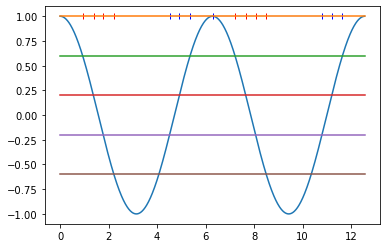

In [6]:
f = plt.figure()
ax = f.gca()
ax.plot(t,sig)
on_raster = ax.plot(t[on_events],
                    np.ones_like(on_events),
                    linewidth=0.1, 
                    color='b',
                    marker="|" )
off_raster = ax.plot(t[off_events],
                    np.ones_like(off_events),
                    linewidth=0.1, 
                    color='r',
                    marker="|" )

for ythr in np.arange(sig.max(),sig.min(),-th):
    ax.plot([t[0],t[-1]],[ythr,ythr], )

The python implementation is quite slow. It might not look like it for this short signal, but it's a drag, really, when analysing interesting signals with millions of samples. 

In [7]:
%%timeit
th = 0.4
on_events, off_events = hyst_event_detector(sig, th)

419 µs ± 28.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The point of this package is to provide accelerated event detection by implementing the detection code in C. We do not code C directly, but use Cython for convenience. 

In [8]:
%load_ext Cython

In [9]:
%%cython
cimport numpy as np
def hyst_event_detector_cy(np.float64_t[::1] sig, 
                           np.float64_t[::1] on, 
                           np.float64_t[::1] off, 
                           double thr):
    cdef:
        size_t i
        double val
        double last_event
    last_event = sig[0]
    for i in range(sig.shape[0]):
        val = sig[i]
        if val >= (last_event + thr):
            on[i] = 1
            last_event = last_event + thr 
        elif val < (last_event - thr):
            off[i] = 1
            last_event = last_event - thr
    return on, off
    

The result is a dramatic speedup. For long signals it has been observed to be in the area of 250-fold, i.e. two orders of magnitude, easily.

In [10]:
%%timeit
th=0.4
on_events, off_events = hyst_event_detector_cy(sig, 
                                               np.zeros_like(sig),
                                               np.zeros_like(sig),
                                               th)
on_events = np.where(on_events)[0]
off_events = np.where(off_events)[0]


39.7 µs ± 4.62 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


The result is the same.

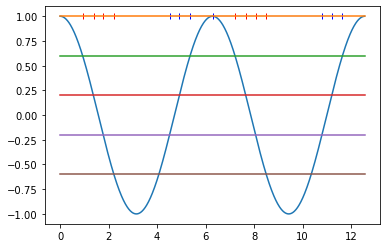

In [11]:
f = plt.figure()
ax = f.gca()
ax.plot(t,sig)
on_raster = ax.plot(t[on_events],
                    np.ones_like(on_events),
                    linewidth=0.1, 
                    color='b',
                    marker="|" )
off_raster = ax.plot(t[off_events],
                    np.ones_like(off_events),
                    linewidth=0.1, 
                    color='r',
                    marker="|" )
from itertools import repeat

for ythr in np.arange(sig.max(),sig.min(),-th):
    ax.plot([t[0],t[-1]],[ythr,ythr], )

## installation with setuptools
We've wrapped the code into a module and use setuptools to compile it, so it can be imported like any other module in python code. 

To compile and install it, run `python setup.py` in the root directory of this repo. You may have to restart the notebook to make it pick up the change.



In [12]:
import os
import sys
sys.path.append(os.path.realpath(os.path.join(os.path.pardir)))
import fads.abs_deadband_sampler

In [15]:
%%timeit
th=0.4
on_events, off_events = \
        fads.abs_deadband_sampler.hyst_event_detector_cy64(np.array(sig), 
                                               np.zeros_like(sig),
                                               np.zeros_like(sig),
                                               th)
on_events = np.where(on_events)[0]
off_events = np.where(off_events)[0]




31.1 µs ± 886 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Since we're dealing with C, there's that pesky type issue. By default, numpy is using 64 bit floats, and we have `hyst_event_detector_cy64` for that (above).

Sometimes though signals are 32 bit, e.g. to save space. This requires a different version of the C code that deals with 32 bit floats: `hyst_event_detector_cy32`. See below. 






In [16]:
%%timeit
sig32 = np.array(sig, dtype=np.float32)
th=0.4
on_events, off_events = \
        fads.abs_deadband_sampler.hyst_event_detector_cy32(sig32, 
                                               np.zeros_like(sig32),
                                               np.zeros_like(sig32),
                                               th)
on_events = np.where(on_events)[0]
off_events = np.where(off_events)[0]




30.9 µs ± 3.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
